In [1]:
import torch
import torchvision
import os
import glob
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import shutil
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# just a preprocessing cell to move images to a new folder
#imagePath = "C:\\Users\\lskus\\OneDrive\\Documents\\TR Scripts on the go\\Cellpose Dataset\\Train"
#maskPath = "C:\\Users\\lskus\\OneDrive\\Documents\\TR Scripts on the go\\Cellpose Dataset\\Mask"
#imagePaths = []
#for data_path in sorted(glob.glob(imagePath + '/*')):
#    imagePaths.append(data_path)
#    
#for i in range(len(imagePaths)):
#    if i%2 != 0:
#        shutil.move(imagePaths[i], maskPath)
#        
#testPath = "C:\\Users\\lskus\\OneDrive\\Documents\\TR Scripts on the go\\Cellpose Dataset\\Test"
#testMaskPath = "C:\\Users\\lskus\\OneDrive\\Documents\\TR Scripts on the go\\Cellpose Dataset\\TestMask"
#
#imagePaths = []
#for data_path in sorted(glob.glob(testPath + '/*')):
#    imagePaths.append(data_path)
#    
#for i in range(len(imagePaths)):
#    if i%2 != 0:
#        shutil.move(imagePaths[i], testMaskPath)

In [3]:
# functions for padding/unpadding
# source https://stackoverflow.com/questions/66028743/how-to-handle-odd-resolutions-in-unet-architecture-pytorch
# https://github.com/seoungwugoh/STM/blob/905f11492a6692dd0d0fa395881a8ec09b211a36/helpers.py#L33
def pad_to(x, stride):
    h, w = x.shape[-2:]

    if h % stride > 0:
        new_h = h + stride - h % stride
    else:
        new_h = h
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
    lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
    pads = (lw, uw, lh, uh)

    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    out = F.pad(x, pads, "constant", 0)

    return out, pads

def unpad(x, pad):
    if pad[2]+pad[3] > 0:
        x = x[:,:,pad[2]:-pad[3],:]
    if pad[0]+pad[1] > 0:
        x = x[:,:,:,pad[0]:-pad[1]]
    return x

In [4]:
import torch.nn as nn
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.ConvBlock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), #inplace=True can slightly reduce memory usage
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.ConvBlock(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.ConvBlock = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        s = self.ConvBlock(x) #skip connection
        p = self.pool(s) #pass maxpool2d to next layer of network
        return (p, s)
    
#decoder just for autoencoder, change for UNet
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(out_channels, out_channels)

    def forward(self, p):
        x = self.upConv(p)
        return self.ConvBlock(x)
    
#decoder for UNet
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(in_channels, out_channels)

    def forward(self, p, s):
        x = self.upConv(p)
        x = torch.cat([x, s], dim=1)
        return self.ConvBlock(x)

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Encoder
        self.encoder1 = EncoderBlock(1, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Decoder
        self.decoder1 = UpBlock(1024, 512)
        self.decoder2 = UpBlock(512, 256)
        self.decoder3 = UpBlock(256, 128)
        self.decoder4 = UpBlock(128, 64)
        
        # Final Layer, take out sigmoid if using BCEWithLogitsLoss
        self.decoded = nn.Sequential(nn.Conv2d(64, 1, 1)
                                     #nn.Sigmoid()
                                    )
        
        
    def forward(self, x):
        p1, s1 = self.encoder1(x)
        p2, s2 = self.encoder2(p1)
        p3, s3 = self.encoder3(p2)
        p4, s4 = self.encoder4(p3)
        
        b = self.bottleneck(p4)
        
        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        decoded = self.decoded(d4)
        
        return decoded

In [6]:
# custom loss functions from
# https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388#:~:text=Dice%20Coefficient&text=Dice%20coefficient%20is%20a%20measure,while%200%20indicates%20no%20overlap.&text=Dice%20Loss%20%3D%201%20%E2%80%94%20Dice%20Coefficient.
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    # add sigmoid since we take it out to use BCEWithLogitsLoss
    dicescore = dice_loss(nn.functional.sigmoid(inputs), target)
    bcescore = nn.BCEWithLogitsLoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [7]:
# initialize model
model = UNet()
model.to(device)
 
# Validation using MSE Loss function
loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 3e-4,
                             weight_decay = 1e-8
                            )

In [8]:
# pathway for image folder
imagePath = "/project/trlab/CellposeDataset/Train"
maskPath = "/project/trlab/CellposeDataset/Mask"

# try with single image
#imagePath = "/project/trlab/SingleIm"
#maskPath = "/project/trlab/SingleMask"

imagePaths = []
maskPaths = []
for data_path in sorted(glob.glob(imagePath + '/*')):
    imagePaths.append(data_path)
    
for data_path in sorted(glob.glob(maskPath + '/*')):
    maskPaths.append(data_path)
    
#print(imagePaths)
#print(maskPaths)

In [9]:
# Create Dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imagePaths, maskPaths):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        
    def transform(self, image, mask):
        # standardize to values between 0 and 1 for faster convergence
        image = image/255.0
        image = image.astype('float32')
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Transfer to device
        image = image.to(device)
        mask = mask.to(device)
        
        # Random crop (not gonna do this for this run through since the images are all different sizes)
        #i, j, h, w = T.RandomCrop.get_params(image, output_size=(512, 512))
        #image = TF.crop(image, i, j, h, w)
        #mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # Random rotation
        if random.random() > 0.5:
            angle = random.randint(-90,90)
            image = TF.rotate(image,angle)
            mask = TF.rotate(mask,angle)
            
        # Random Gaussian Blur
        if random.random() > 0.5:
            image = TF.gaussian_blur(image, 3, 0.15)
            
        # Random sharpness
        sharpness = random.random()
        shift = random.uniform(0.2,1.8)
        if sharpness > 0.5:
            image = TF.adjust_sharpness(image, shift)
            
        # Random contrast not sure why this isn't working, current documentation says one channel tensors are fine
        # but it's throwing an error saying you need 3 channels
        #contrast = random.random()
        #if contrast > 0.5:
        #    image = TF.adjust_contrast(image, 2)
        #elif contrast < 0.25:
        #    image = TF.adjust_contrast(image, 0.5)
        
        # Random brightness
        brightness = random.random()
        shift = random.uniform(0.2,1.8)
        if brightness > 0.5:
            image = TF.adjust_brightness(image, shift)
            
        # Random Affine
        shearx = random.randint(-45,45)
        sheary = random.randint(-45,45)
        transx = random.randint(-20,20)
        transy = random.randint(-20,20)
        if random.random() > 0.5:
            image = TF.affine(image, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            mask = TF.affine(mask, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            
        # pad to correct size for UNet
        #image, pads = pad_to(image,32)
        #mask, pads = pad_to(mask,32)
        image = TF.center_crop(image, [512,512])
        mask = TF.center_crop(mask, [512,512])

        return image, mask
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]
        
        image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imdecode(np.fromfile(maskPath, dtype=np.uint16), cv2.IMREAD_UNCHANGED)
        mask = Image.open(maskPath)
        mask = np.array(mask)
        mask = cv2.convertScaleAbs(mask) # convert to uint8
        ret, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY) # binarize the mask

        # use RandomChoice with only ony composed transform so it applies the same way to both
        #transform = T.RandomChoice([T.Compose([T.AutoAugment(T.AutoAugmentPolicy.IMAGENET), T.ToTensor()])])
        image, mask = self.transform(image, mask)
            
        return (image, mask)

In [10]:
# from torchvision import datasets
torch.manual_seed(1)

dataset = Dataset(imagePaths = imagePaths,
                  maskPaths = maskPaths
                 )


train_loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 4,
                                     shuffle = True)

In [11]:
epochs = 100
count = 1
outputs = []
losses = []
#test_losses = []

# modify training loop to use automatic mixed precision

# convert model to half precision to save memory
#model.half()

# need to keep batch norm layers at fp32
#for layer in model.modules():
#    if isinstance(layer, nn.BatchNorm2d):
#        layer.float()

scaler = torch.cuda.amp.GradScaler(enabled=True)
    
model.train()
for epoch in range(epochs):
    runningLoss = 0
    for (i,(image, mask)) in enumerate(train_loader):
        
        image = image.to(device)
        mask = mask.to(device)
        
        with torch.cuda.amp.autocast():
            # Output of UNet
            reconstructed = model(image)
       
            # Calculating the loss function
            #loss = loss_function(reconstructed, mask)
            #loss = dice_loss(reconstructed, mask)
            loss = bce_dice_loss(reconstructed, mask)
            runningLoss = runningLoss + loss.item()
            
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        # autocast backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
       
    # Storing the losses in a list for plotting
    losses.append(runningLoss/len(train_loader))
    outputs.append((epochs, image, reconstructed))
    print("epoch", count, "finished")
    count = count + 1

/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished
epoch 16 finished
epoch 17 finished
epoch 18 finished
epoch 19 finished
epoch 20 finished
epoch 21 finished
epoch 22 finished
epoch 23 finished
epoch 24 finished
epoch 25 finished
epoch 26 finished
epoch 27 finished
epoch 28 finished
epoch 29 finished
epoch 30 finished
epoch 31 finished
epoch 32 finished
epoch 33 finished
epoch 34 finished
epoch 35 finished
epoch 36 finished
epoch 37 finished
epoch 38 finished
epoch 39 finished
epoch 40 finished
epoch 41 finished
epoch 42 finished
epoch 43 finished
epoch 44 finished
epoch 45 finished
epoch 46 finished
epoch 47 finished
epoch 48 finished
epoch 49 finished
epoch 50 finished
epoch 51 finished
epoch 52 finished
epoch 53 finished
epoch 54 finished
epoch 55 finished
epoch 56 finished
e

epoch 438 finished
epoch 439 finished
epoch 440 finished
epoch 441 finished
epoch 442 finished
epoch 443 finished
epoch 444 finished
epoch 445 finished
epoch 446 finished
epoch 447 finished
epoch 448 finished
epoch 449 finished
epoch 450 finished
epoch 451 finished
epoch 452 finished
epoch 453 finished
epoch 454 finished
epoch 455 finished
epoch 456 finished
epoch 457 finished
epoch 458 finished
epoch 459 finished
epoch 460 finished
epoch 461 finished
epoch 462 finished
epoch 463 finished
epoch 464 finished
epoch 465 finished
epoch 466 finished
epoch 467 finished
epoch 468 finished
epoch 469 finished
epoch 470 finished
epoch 471 finished
epoch 472 finished
epoch 473 finished
epoch 474 finished
epoch 475 finished
epoch 476 finished
epoch 477 finished
epoch 478 finished
epoch 479 finished
epoch 480 finished
epoch 481 finished
epoch 482 finished
epoch 483 finished
epoch 484 finished
epoch 485 finished
epoch 486 finished
epoch 487 finished
epoch 488 finished
epoch 489 finished
epoch 490 fi

epoch 870 finished
epoch 871 finished
epoch 872 finished
epoch 873 finished
epoch 874 finished
epoch 875 finished
epoch 876 finished
epoch 877 finished
epoch 878 finished
epoch 879 finished
epoch 880 finished
epoch 881 finished
epoch 882 finished
epoch 883 finished
epoch 884 finished
epoch 885 finished
epoch 886 finished
epoch 887 finished
epoch 888 finished
epoch 889 finished
epoch 890 finished
epoch 891 finished
epoch 892 finished
epoch 893 finished
epoch 894 finished
epoch 895 finished
epoch 896 finished
epoch 897 finished
epoch 898 finished
epoch 899 finished
epoch 900 finished
epoch 901 finished
epoch 902 finished
epoch 903 finished
epoch 904 finished
epoch 905 finished
epoch 906 finished
epoch 907 finished
epoch 908 finished
epoch 909 finished
epoch 910 finished
epoch 911 finished
epoch 912 finished
epoch 913 finished
epoch 914 finished
epoch 915 finished
epoch 916 finished
epoch 917 finished
epoch 918 finished
epoch 919 finished
epoch 920 finished
epoch 921 finished
epoch 922 fi

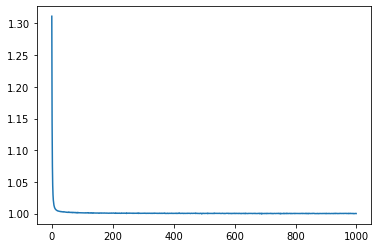

In [12]:
plt.plot(np.arange(epochs),losses)

In [13]:
torch.save(model, "/project/trlab/CellposeDataset/UNetCellpose2.pth")
print("done!")

done!


/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
average loss:  1.0010047698722166


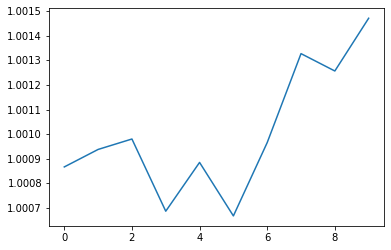

In [14]:
# test loop
# pathway for image folder
imagePath = "/project/trlab/CellposeDataset/Test"
maskPath = "/project/trlab/CellposeDataset/TestMask"

# try with single image
#imagePath = "/project/trlab/SingleIm"
#maskPath = "/project/trlab/SingleMask"

imagePaths = []
maskPaths = []
for data_path in sorted(glob.glob(imagePath + '/*')):
    imagePaths.append(data_path)
    
for data_path in sorted(glob.glob(maskPath + '/*')):
    maskPaths.append(data_path)
    
torch.manual_seed(1)

dataset = Dataset(imagePaths = imagePaths,
                  maskPaths = maskPaths
                 )

test_loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 4,
                                     shuffle = True)

epochs = 10
count = 1
outputs = []
losses = []
#test_losses = []

# modify training loop to use automatic mixed precision

# convert model to half precision to save memory
#model.half()

# need to keep batch norm layers at fp32
#for layer in model.modules():
#    if isinstance(layer, nn.BatchNorm2d):
#        layer.float()

scaler = torch.cuda.amp.GradScaler(enabled=True)
    
model.eval()
with torch.no_grad():
    for epoch in range(epochs):
        runningLoss = 0
        for (i,(image, mask)) in enumerate(test_loader):

            image = image.to(device)
            mask = mask.to(device)

            with torch.cuda.amp.autocast():
                # Output of UNet
                reconstructed = model(image)

                # Calculating the loss function
                #loss = loss_function(reconstructed, mask)
                #loss = dice_loss(reconstructed, mask)
                loss = bce_dice_loss(reconstructed, mask)
                runningLoss = runningLoss + loss.item()

        # Storing the losses in a list for plotting
        losses.append(runningLoss/len(test_loader))
        outputs.append((epochs, image, reconstructed))
        print("epoch", count, "finished")
        count = count + 1
        
plt.plot(np.arange(epochs),losses)
print("average loss: ", sum(losses)/len(losses))


In [ ]:
model = torch.load("UNetCellpose.pth")

In [131]:
# see what output looks like with test image
plt.rcParams["figure.figsize"] = (10,10)
testInput1 = "/project/trlab/CellposeDataset/Test/000_img.png"
test1 = cv2.imdecode(np.fromfile(testInput1, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
tensorTransform = T.ToTensor()
test1 = test1/255.0
test1 = test1.astype('float32')
img_tensor = tensorTransform(test1).unsqueeze(0).to('cuda')
img_tensor = TF.center_crop(img_tensor, (512,512))
output = model(img_tensor)
# insert this line when usinfg bce with dice loss
output = torch.sigmoid(output)
# also try arctan function
#output = torch.arctan(output)
output = output.squeeze()
output = output.detach().cpu().numpy()

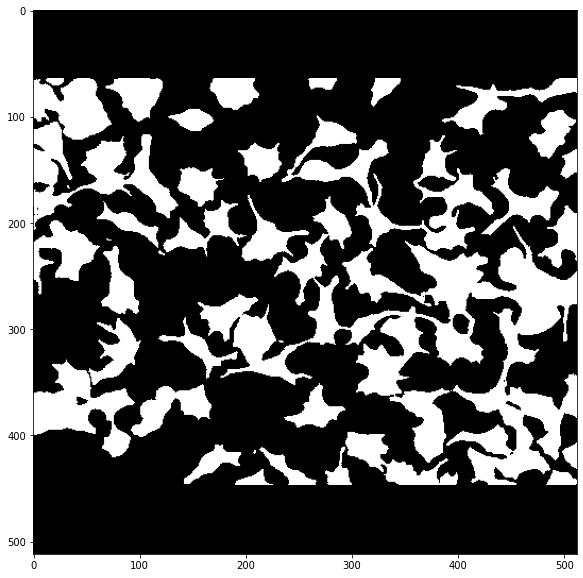

In [134]:
scaledOut = output/np.amax(output)
ret, thresh1 = cv2.threshold(scaledOut, 0.01, 1, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray')
plt.show()

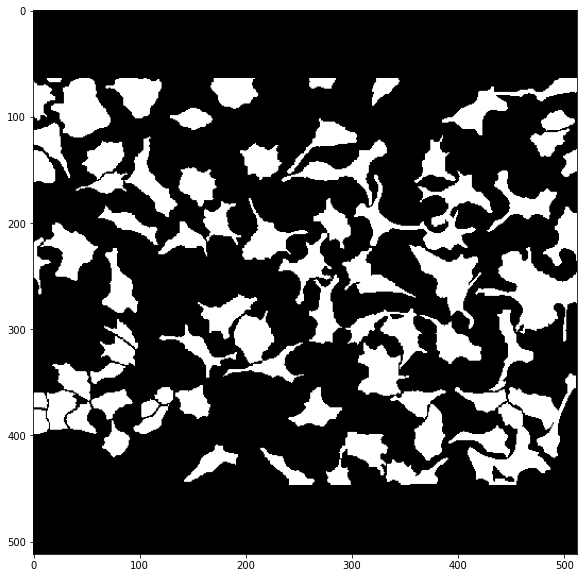

In [67]:
gt_mask = Image.open("/project/trlab/CellposeDataset/TestMask/000_masks.png")
gt_mask = np.array(gt_mask)
gt_mask = cv2.convertScaleAbs(gt_mask) # convert to uint8
ret, gt_mask = cv2.threshold(gt_mask, 0, 1, cv2.THRESH_BINARY) # binarize the mask
mask_tensor = tensorTransform(gt_mask).unsqueeze(0).to('cuda')
mask_tensor = TF.center_crop(mask_tensor, (512,512))
gt_mask = TF.to_pil_image(mask_tensor.squeeze())
plt.imshow(gt_mask,cmap='gray')

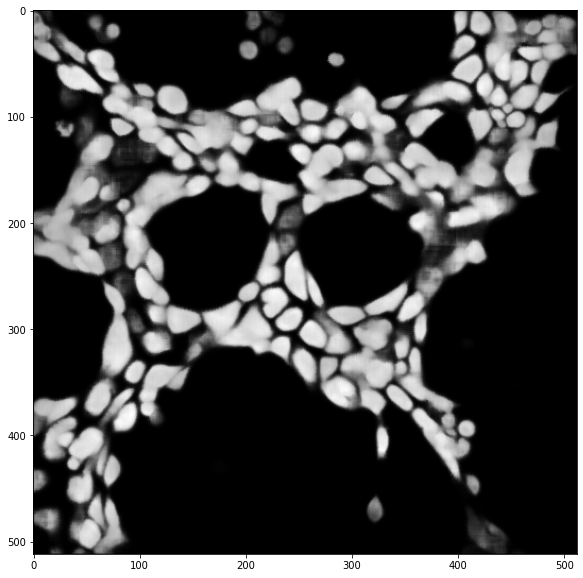

In [138]:
# try again with actual test image from our set
testInput1 = "/project/trlab/imagePath/BzATP1 f1.tif"
test1 = cv2.imdecode(np.fromfile(testInput1, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
tensorTransform = T.ToTensor()
test1 = test1/255.0
test1 = test1.astype('float32')
img_tensor = tensorTransform(test1).unsqueeze(0).to('cuda')
output = model(img_tensor)
# insert this line when using bce with dice loss
output = torch.sigmoid(output)
# also try arctan function
#output = torch.arctan(output)
output = output.squeeze()
output = output.detach().cpu().numpy()
plt.imshow(output, cmap='gray')
plt.show()

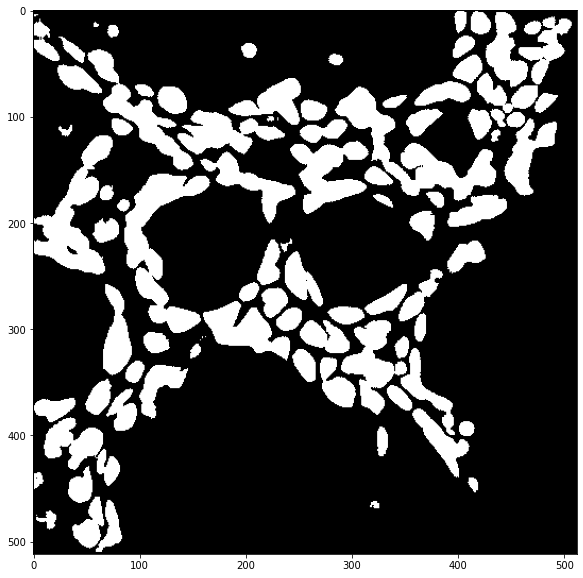

In [139]:
scaledOut = output/np.amax(output)
ret, thresh1 = cv2.threshold(scaledOut, 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray')

In [ ]:
# this looks really weird and for some reason the values are on the range of 0.001 to 0.01 instead of 0 to 1 for the
# first version of the cell pose pretrained model
# re train with different data loading?